# **Rock Image Classification**

Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import umap
import torch
import shutil
import time
import torch.nn as nn
import torch.optim as optim
from re import IGNORECASE
from inspect import isgenerator
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from itertools import product
from copy import deepcopy
from google.colab import files
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import LocallyLinearEmbedding, TSNE, MDS
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

Load In Data

In [ ]:
# Path to zip
zip_path = "/content/360 Rocks.zip"
extract_path = "/content/images"

# Extract all files from the zip archive to the extract_path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define image paths
image_paths = []
for root, _, files in os.walk(extract_path):
    for fname in files:
        if fname.lower().endswith(".jpg"):
            image_paths.append(os.path.join(root, fname))

image_paths.sort()

# Load and flatten RGB images
image_data_rgb = []
for path in image_paths:
    img = Image.open(path).resize((64, 64))
    img_array = np.array(img)
    image_data_rgb.append(img_array.flatten())

image_data_rgb = np.array(image_data_rgb)
print("RGB Image data shape:", image_data_rgb.shape)

# Save a copy
image_data_copy = image_data_rgb.copy()

Found 360 files belonging to 3 classes.
Found 120 files belonging to 3 classes.


## **PCA**

In [ ]:
# Apply PCA to Rocks to reduce dimensionality
pca = PCA(n_components=0.95)
data_reduced = pca.fit_transform(image_data_copy)
print(pca.n_components_)
print(f'Perserved Variance: {round(np.sum(pca.explained_variance_ratio_),4)}')
print(data_reduced.shape)

196
Perserved Variance: 0.9502
(480, 196)


In order to perserve 95% variance we need **162 principal components**. A reduction of 12,126 principal components.

## **Plots of Reconstructed Images**

In [ ]:
# Apply PCA to Rocks to reduce dimensionality keeping 90% Variance
pca_90 = PCA(n_components=0.90)
data_reduced_90 = pca_90.fit_transform(image_data_copy)

# Reconstruct images from reduced dimensions
reconstructed_images = pca_90.inverse_transform(data_reduced_90)

print(pca_90.n_components_)

111


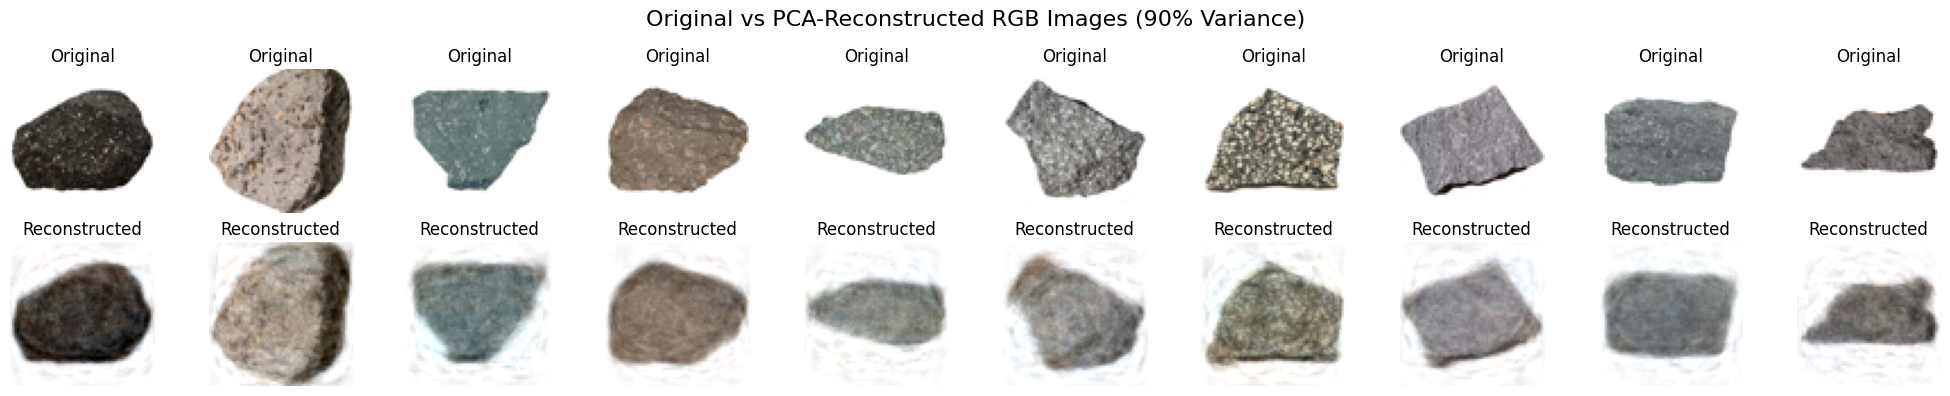

In [ ]:
# Plot 10 images
indices = list(range(10))
plt.figure(figsize=(20, 4))

for i, idx in enumerate(indices):
    # Original
    plt.subplot(2, 10, i + 1)
    original = image_data_rgb[idx].reshape(64, 64, 3).astype(np.uint8)
    plt.imshow(original)
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, 10, i + 11)
    reconstructed = np.clip(reconstructed_images[idx], 0, 255).reshape(64, 64, 3).astype(np.uint8)
    plt.imshow(reconstructed)
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Original vs PCA-Reconstructed RGB Images (90% Variance)", fontsize=16)
plt.tight_layout()
plt.show()

## **Use Visuals to Identify Clusters**


In [ ]:
image_paths = []
images = []
labels = []  # will hold values 0 (I), 1 (M), 2 (S)

label_map = {'I': 0, 'M': 1, 'S': 2}  #\\

for root, _, files in os.walk("/content/images"):
    for fname in sorted(files):
        if fname.lower().endswith('.jpg'):
            label_char = fname[0].upper()
            if label_char in label_map:
                full_path = os.path.join(root, fname)
                img = Image.open(full_path).resize((64, 64))
                images.append(np.array(img))
                image_paths.append(full_path)
                labels.append(label_map[label_char])

### Reduce to 2 dimensions

In [ ]:
# Apply PCA to Rocks to reduce to 2 dimensions
pca = PCA(n_components=2)
data_reduced_2 = pca.fit_transform(image_data_copy)

print(pca.n_components_)
print(f'Perserved Variance: {round(np.sum(pca.explained_variance_ratio_),4)}')
print(data_reduced_2.shape)

2
Perserved Variance: 0.3658
(480, 196)


When reducing down to two dimensions we keep 36.82% variance.

### 2D Scatter Plot

In [ ]:
labels_raw = [os.path.basename(path)[0] for path in image_paths]

label_map = {'I': 0, 'S': 1, 'M': 2}
y = np.array([label_map[label] for label in labels_raw])

In [ ]:
def plot_scatter(reduced_data, labels, images, name):
    label_colors = {0: 'red', 1: 'orange', 2: 'green'}
    label_names = {0: 'I', 1: 'S', 2: 'M'}

    plt.figure(figsize=(13, 10))

    for lab in np.unique(labels):
        lab_label = label_names[lab]
        indices = np.where(labels == lab)
        plt.scatter(
            reduced_data[indices, 0],
            reduced_data[indices, 1],
            label=lab_label,
            color=label_colors[lab],
            s=40,
            edgecolors='black',
            linewidth=0.5
        )

    for i in indices[0]:
        if i % 3 == 0 and images is not None:
            image = images[i]
            if image.ndim == 1:  # flattened RGB image
                image = image.reshape((64, 64, 3))
            imagebox = OffsetImage(image, zoom=0.35)
            ab = AnnotationBbox(
                imagebox, reduced_data[i],
                xybox=(0, -20),
                boxcoords="offset points",
                box_alignment=(0.5, 1),
                frameon=False
            )
            plt.gca().add_artist(ab)

    plt.title(f'{name} Scatter Plot of Reduced Data with Images')
    plt.axis("off")
    plt.legend()
    plt.show()

PCA Plot

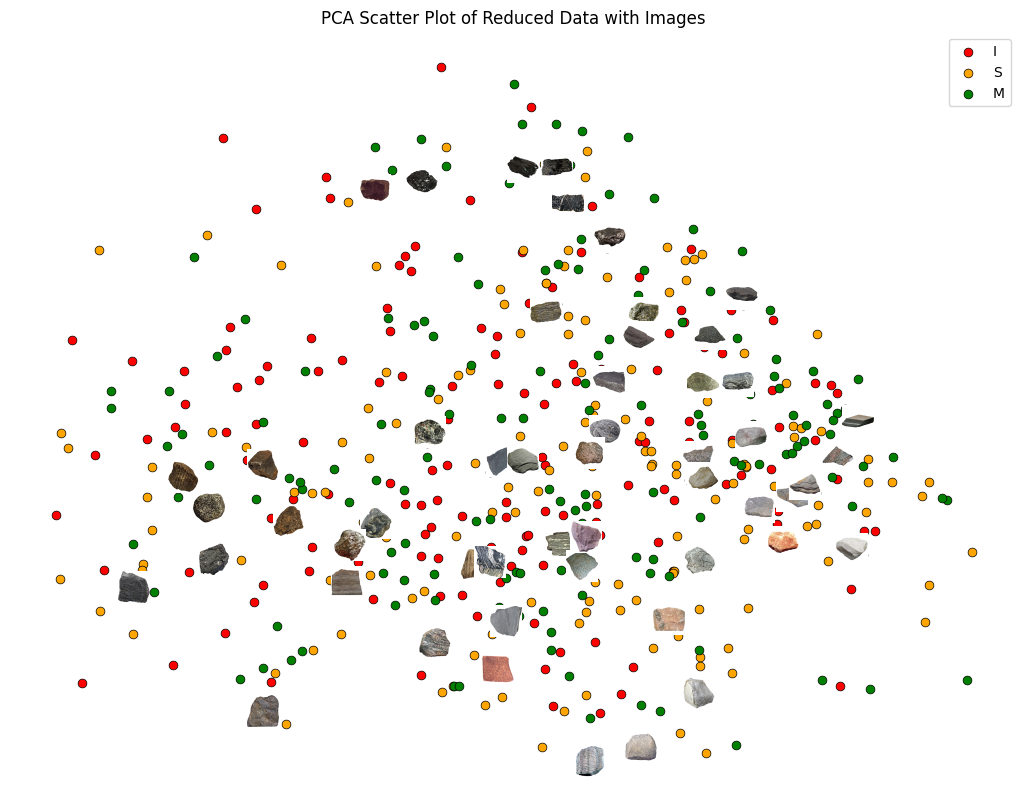

In [ ]:
plot_scatter(data_reduced_2, y, image_data_copy, "PCA")

t-SNE Plot

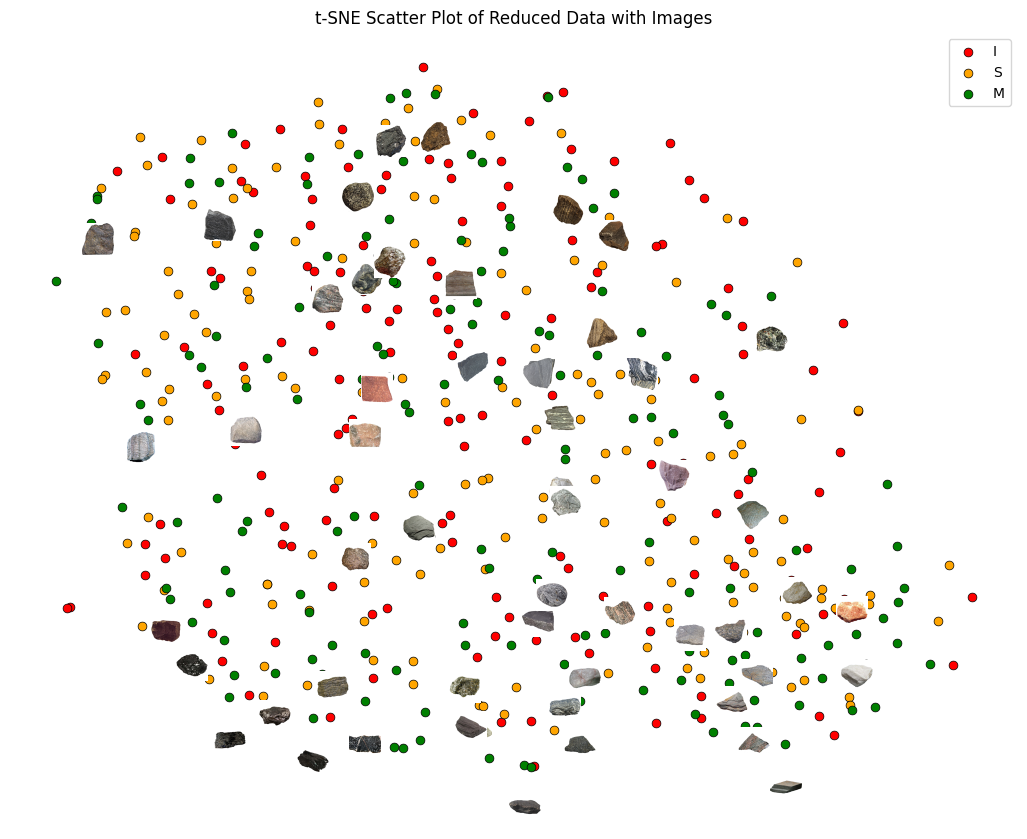

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
data_tsne = tsne.fit_transform(image_data_copy)
plot_scatter(data_tsne, y, image_data_copy, "t-SNE")

LLE Plot

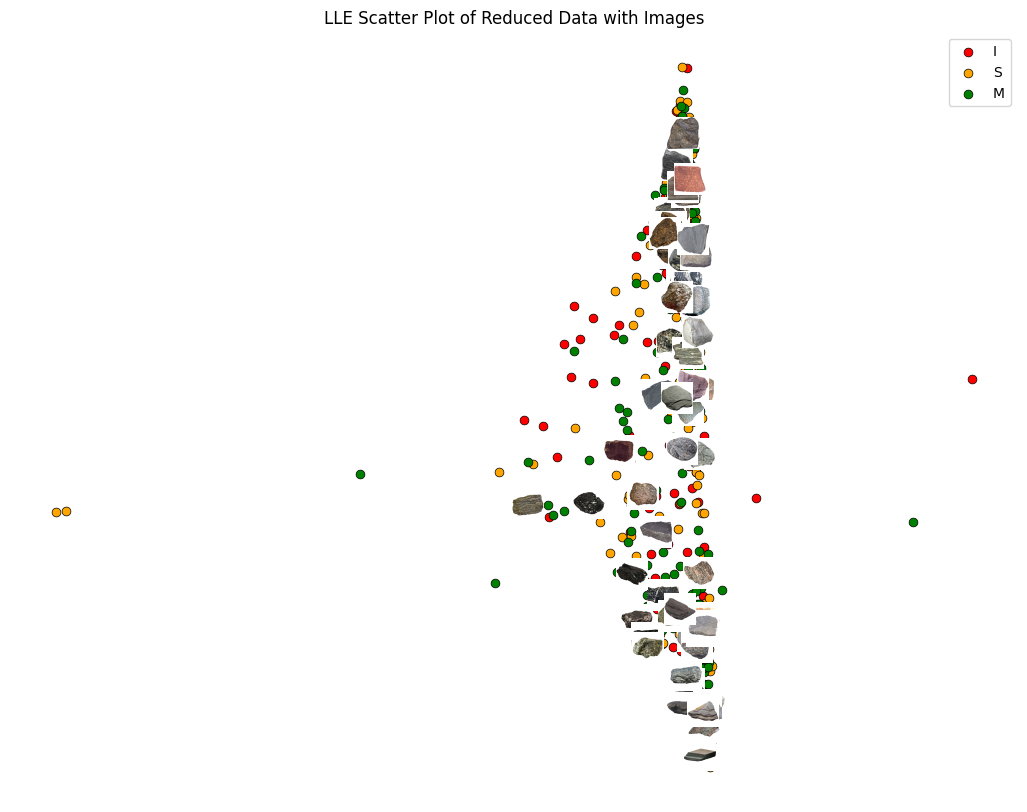

In [ ]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
data_lle = lle.fit_transform(image_data_copy)
plot_scatter(data_lle, y, image_data_copy, "LLE")

UMAP Plot

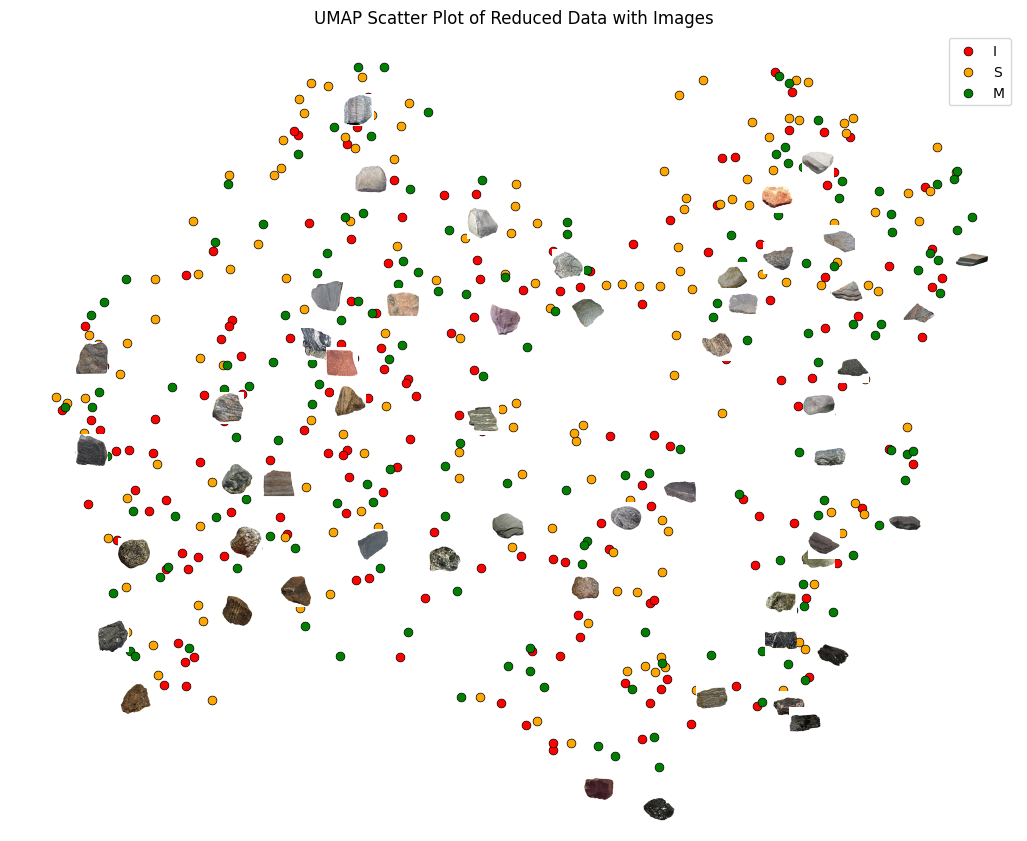

In [ ]:
umap_model = umap.UMAP(n_components=2, random_state=42)
data_umap = umap_model.fit_transform(image_data_copy)
plot_scatter(data_umap, y, image_data_copy, "UMAP")

### Summary

Looking at the PCA plot we can see decent separation between M and I, but there is decent overlap from S. LLE shows a structured vertical alignment of the 3 categories, although the clusters slightly overlap, the distribution shows differences between the groups. Simular to PCA, t-SNE does fairly well with seperating the rock catrgories, there are a couple overlaps, but it is mostly structred well. Lastly UMAP provides lots of serperation in some palces, but lots of clustering in other areas. It seems that the edges of the plot have the most overlap, with seperation in the middle

## K-Means

### Silhouette Score

Use Silhouette Score to find the optimal number of clusters

In [ ]:
# data_reduced is PCA with 95% variance kept
K = [KMeans(n_clusters=k, random_state=42).fit(data_reduced) for k in range(1, 10)]
sil_scores = [silhouette_score(data_reduced, model.labels_) for model in K[1:]]

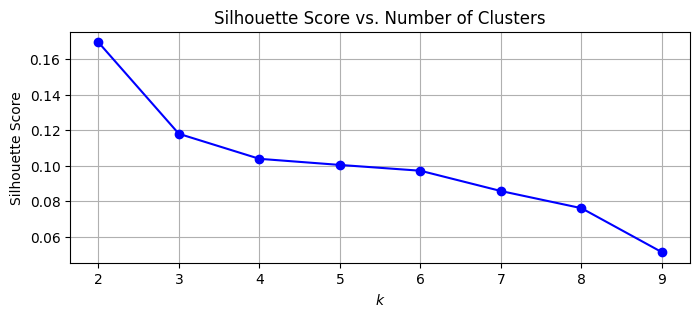

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), sil_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid()
plt.show()

Using Silhouette Score we see the the most optimal number of clusters is 2. Which makes sense beacuse if we look back at our PCA plot from before M and I were seperated well, while S was heavily overlapped. Since we are classifiying 3 types of rocks we would hope the Silhouette Score would be highest for 3 clusters.

### Clusters accuracy and matrix

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(data_reduced)

In [ ]:
def match_labels(true_labels, cluster_labels):
    confusion = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-confusion)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    aligned_preds = np.array([mapping[cl] for cl in cluster_labels])
    return aligned_preds

aligned_preds = match_labels(y, cluster_labels)

# Accuracy
acc = accuracy_score(y, aligned_preds)
print(f"Clustering Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y, aligned_preds)
print("Confusion Matrix:\n", cm)

Clustering Accuracy: 0.3688
Confusion Matrix:
 [[59 56 45]
 [46 69 45]
 [48 63 49]]


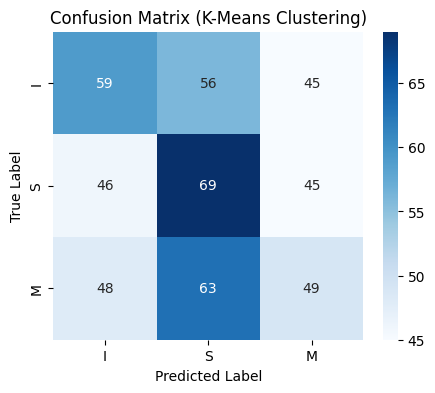

In [ ]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["I", "S", "M"], yticklabels=["I", "S", "M"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (K-Means Clustering)")
plt.show()

### Visualize

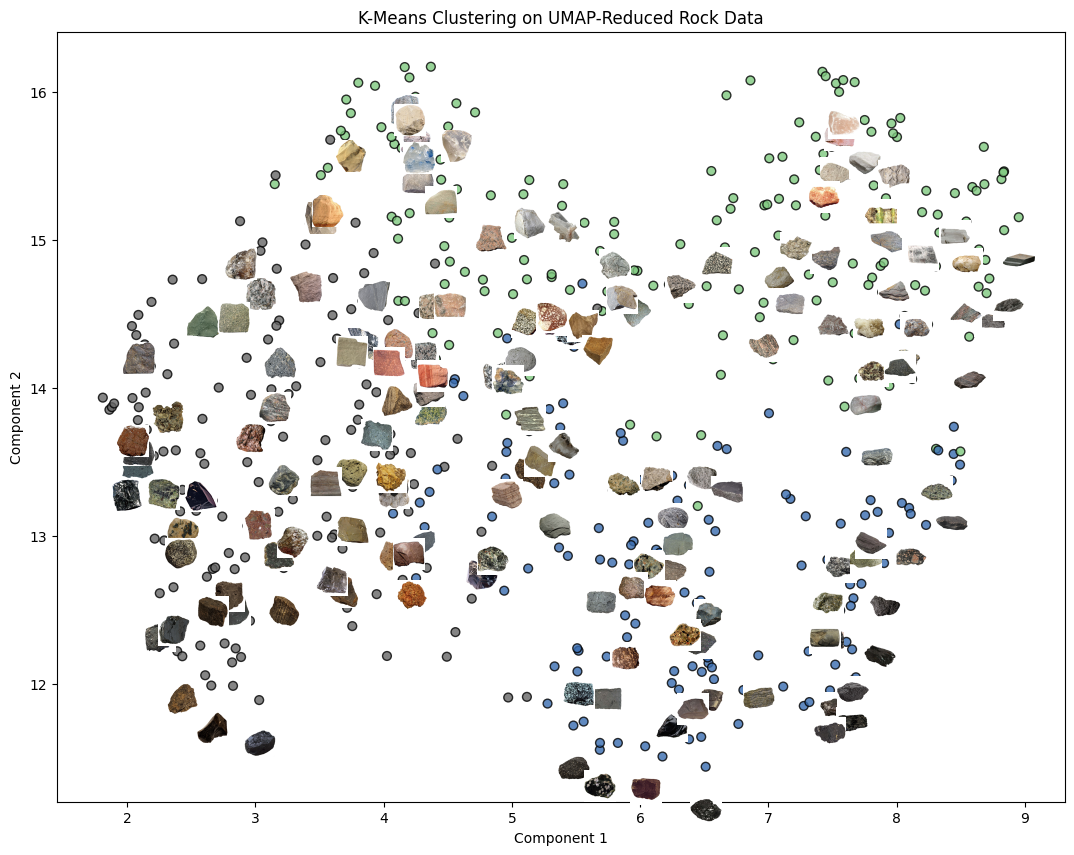

In [ ]:
X = data_umap

plt.figure(figsize=(13, 10))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='Accent', s=40, edgecolors='k', alpha=0.8)
plt.title("K-Means Clustering on UMAP-Reduced Rock Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

for i in range(len(X)):
    if i % 3 == 0:
        img = image_data_rgb[i].reshape(64, 64, 3)
        imagebox = OffsetImage(img, zoom=0.35)
        ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]),
                            xybox=(0, -20), boxcoords="offset points",
                            box_alignment=(0.5, 1), frameon=False)
        plt.gca().add_artist(ab)

plt.show()


## EM

### BIC & AIC

We'll use BIC and AIC to compare and select the better method

In [ ]:
# data_reduced is PCA with 95% variance kept
gm = [GaussianMixture(n_components=k, random_state=42).fit(data_reduced) for k in range(1, 10)]
bics = [model.bic(data_reduced) for model in gm]
aics = [model.aic(data_reduced) for model in gm]
ks = range(1, 10)

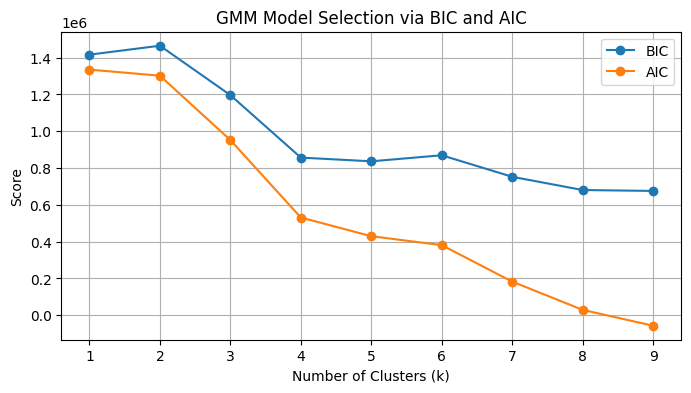

In [ ]:
# Plot BIC and AIC
plt.figure(figsize=(8, 4))
plt.plot(ks, bics, label='BIC', marker='o')
plt.plot(ks, aics, label='AIC', marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.title("GMM Model Selection via BIC and AIC")
plt.xticks(ks)
plt.legend()
plt.grid()
plt.show()

Looking at BIC and AIC we see that they both reach a minimum at 7 clusters, so 7 clusters would be the best for our model. However since we are classifying 3 types of rocks k = 3 would still be best.

### Accuracy & Matrix

In [ ]:
gm = GaussianMixture(n_components=3, random_state=42).fit(data_reduced)
gm_labels = gm.fit_predict(data_reduced)

aligned_preds = match_labels(y, gm_labels)

# Accuracy
acc = accuracy_score(y, aligned_preds)
print(f"Clustering Accuracy (GMM): {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y, aligned_preds)
print("Confusion Matrix:\n", cm)

Clustering Accuracy (GMM): 0.3750
Confusion Matrix:
 [[58 61 41]
 [46 75 39]
 [46 67 47]]


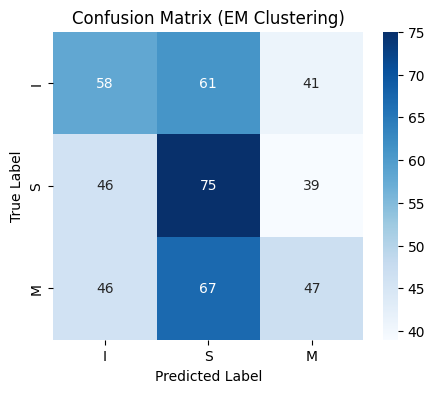

In [ ]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["I", "S", "M"], yticklabels=["I", "S", "M"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (EM Clustering)")
plt.show()

### Plot

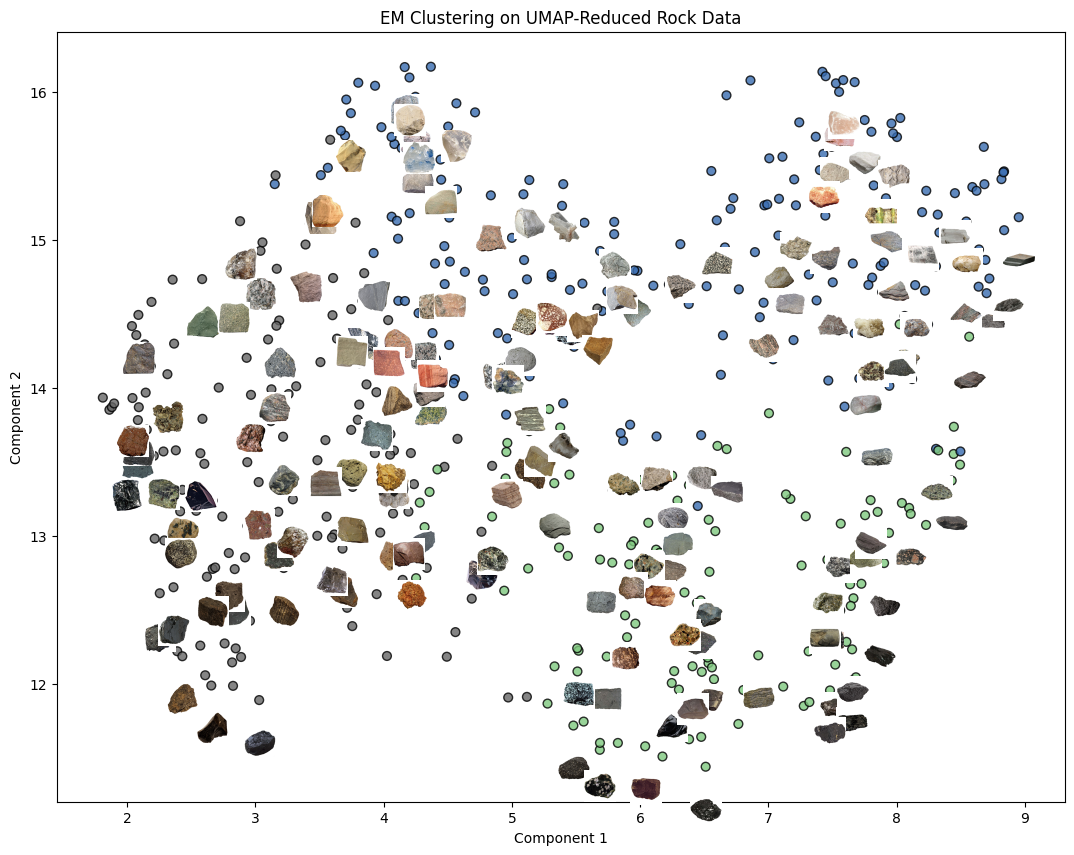

In [ ]:
X = data_umap
em_labels = gm.predict(data_reduced)

plt.figure(figsize=(13, 10))
plt.scatter(X[:, 0], X[:, 1], c=em_labels, cmap='Accent', s=40, edgecolors='k', alpha=0.8)
plt.title("EM Clustering on UMAP-Reduced Rock Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

for i in range(len(X)):
    if i % 3 == 0:
        img = image_data_rgb[i].reshape(64, 64, 3)
        imagebox = OffsetImage(img, zoom=0.35)
        ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]),
                            xybox=(0, -20), boxcoords="offset points",
                            box_alignment=(0.5, 1), frameon=False)
        plt.gca().add_artist(ab)

plt.show()


### Generate 20 new rocks

In [ ]:
pca_95 = PCA(n_components=0.95)
data_reduced_95 = pca_95.fit_transform(image_data_copy)

X_new, y_new = gm.sample(20)
X_recovered = pca_95.inverse_transform(X_new)
X_images = X_recovered.reshape(-1, 64, 64, 3)

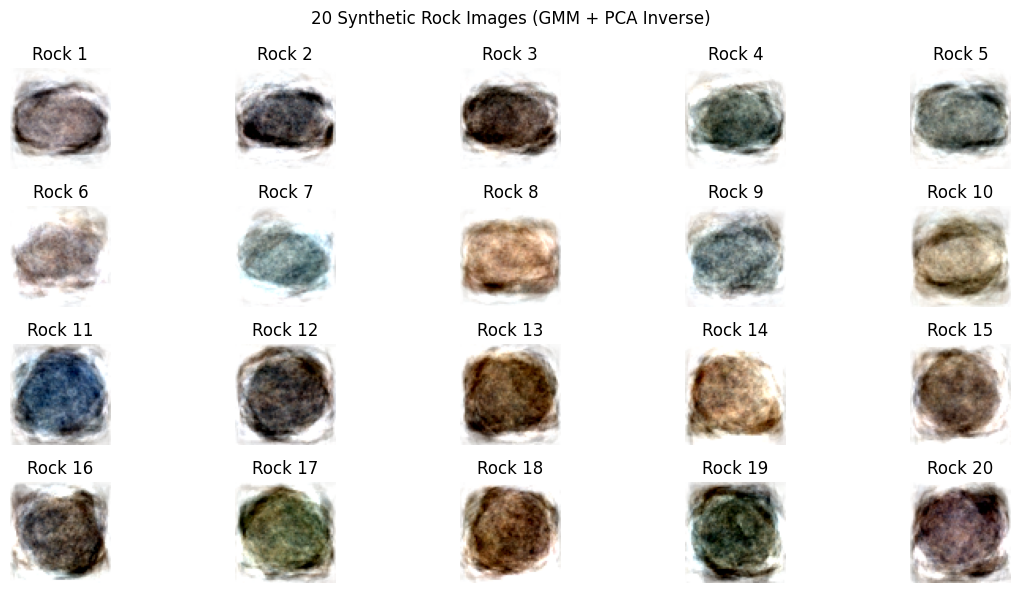

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(np.clip(X_images[i] / 255, 0, 1))
    plt.axis("off")
    plt.title(f"Rock {i+1}")
plt.suptitle("20 Synthetic Rock Images (GMM + PCA Inverse)")
plt.tight_layout()
plt.show()

## Build Neural Network

### Training Time

In [ ]:
def extract_and_organize(zip_path, extract_root):
    # Temp extract
    temp_path = os.path.join(extract_root, "temp")
    os.makedirs(temp_path, exist_ok=True)

    # Extract
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_path)

    # Create label folders: I, M, S
    for label in ['I', 'M', 'S']:
        os.makedirs(os.path.join(extract_root, label), exist_ok=True)

    # Move files to label folders
    for fname in os.listdir(temp_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')) and len(fname) > 0:
            label = fname[0].upper()
            if label in ['I', 'M', 'S']:
                src = os.path.join(temp_path, fname)
                dst = os.path.join(extract_root, label, fname)
                shutil.move(src, dst)

    # Clean up temp folder
    shutil.rmtree(temp_path)

# Paths
train_zip_path = "/content/360 Rocks.zip"
val_zip_path = "/content/120 Rocks.zip"

train_dir = "/content/train_rocks"
val_dir = "/content/val_rocks"

# Extract and organize
extract_and_organize(train_zip_path, train_dir)
extract_and_organize(val_zip_path, val_dir)

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(64, 64),
    batch_size=32,
    label_mode='categorical',
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(64, 64),
    batch_size=32,
    label_mode='categorical',
    seed=42
)

Found 360 files belonging to 3 classes.
Found 120 files belonging to 3 classes.


Run the model

In [ ]:
# Define model
inputs = tf.keras.Input(shape=(64, 64, 3))
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax',
                       kernel_regularizer=regularizers.l2(0.001))(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile using SGD optimizer with default learning rate (0.01) + momentum
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary and training
model.summary()

start = time.time()
history = model.fit(train_ds, validation_data=val_ds, epochs=20)
print("Training time:", round(time.time() - start, 2), "seconds")


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117,059 (8.08 MB)

 Trainable params: 2,117,059 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 442ms/step - accuracy: 0.3912 - loss: 1.4664 - val_accuracy: 0.3583 - val_loss: 1.4034
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.3885 - loss: 1.4005 - val_accuracy: 0.4417 - val_loss: 1.4008
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.3354 - loss: 1.4041 - val_accuracy: 0.4250 - val_loss: 1.3991
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.3762 - loss: 1.4006 - val_accuracy: 0.4250 - val_loss: 1.3920
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4402 - loss: 1.3881 - val_accuracy: 0.4167 - val_loss: 1.3846
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.3970 - loss: 1.3807 - val_accuracy: 0.4583 - val_loss: 1.3705
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4839 - loss: 1.3645 - val_accuracy: 0.3750 - val_loss: 1.3578
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.4361 - loss: 1.3445 - val_accuracy: 0.

### Training and Validation Accuracy

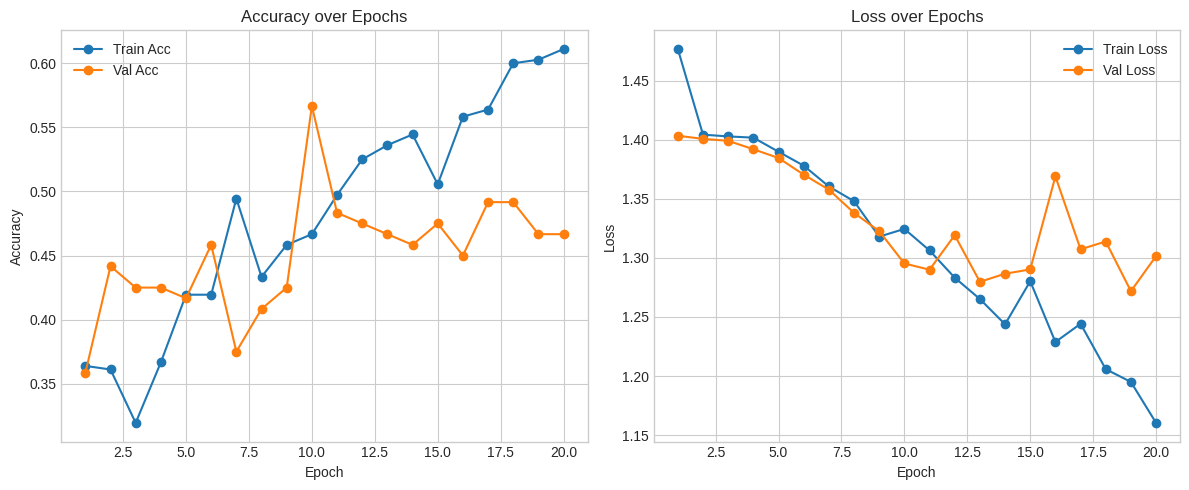

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.style.use('seaborn-v0_8-whitegrid')

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Acc', marker='o')
plt.plot(epochs, val_acc, label='Val Acc', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Parameters

In [ ]:
total_params = model.count_params()

bias_params = sum(
    tf.size(var).numpy()
    for var in model.trainable_variables
    if 'bias' in var.name
)

print(f"Total Parameters: {total_params}")
print(f"Bias Parameters: {bias_params}")

Total Parameters: 2117059
Bias Parameters: 227


### See how the model does during training

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117,059 (8.08 MB)

 Trainable params: 2,117,059 (8.08 MB)

 Non-trainable params: 0 (0.00 B)


========== TRAINING: First Half ==========
Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - accuracy: 0.3268 - loss: 1.4355 - val_accuracy: 0.3333 - val_loss: 1.4059
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.3459 - loss: 1.4080 - val_accuracy: 0.3333 - val_loss: 1.4023
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.3616 - loss: 1.4012 - val_accuracy: 0.3833 - val_loss: 1.3967
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.3656 - loss: 1.3947 - val_accuracy: 0.4750 - val_loss: 1.3878
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4010 - loss: 1.3829 - val_accuracy: 0.4750 - val_loss: 1.3759
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4390 - loss: 1.3772 - val_accuracy: 0.3750 - val_loss: 1.3840
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.4496 - loss: 1.3722 - val_accuracy: 0.4500 - val_loss: 1.3372
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accura

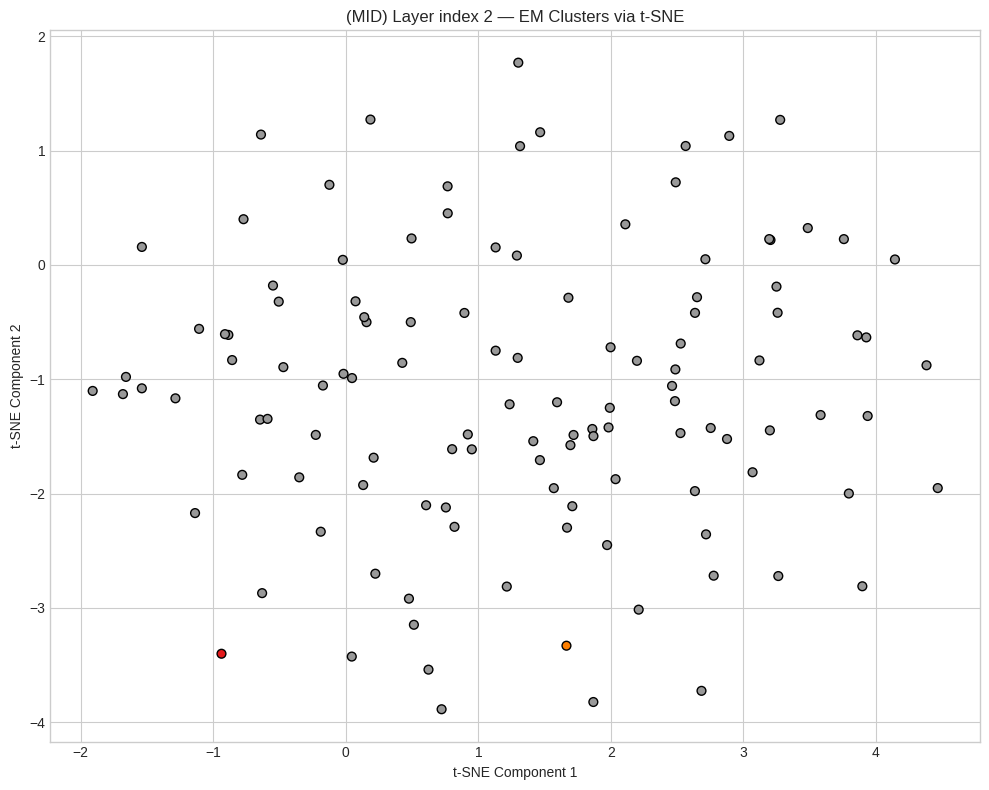


--- Clustering Neuron Activity from Layer index: 4 (MID) ---
Clustering Accuracy (MID): 0.4417
Confusion Matrix:
 [[ 1 22 17]
 [ 0 24 16]
 [ 0 12 28]]


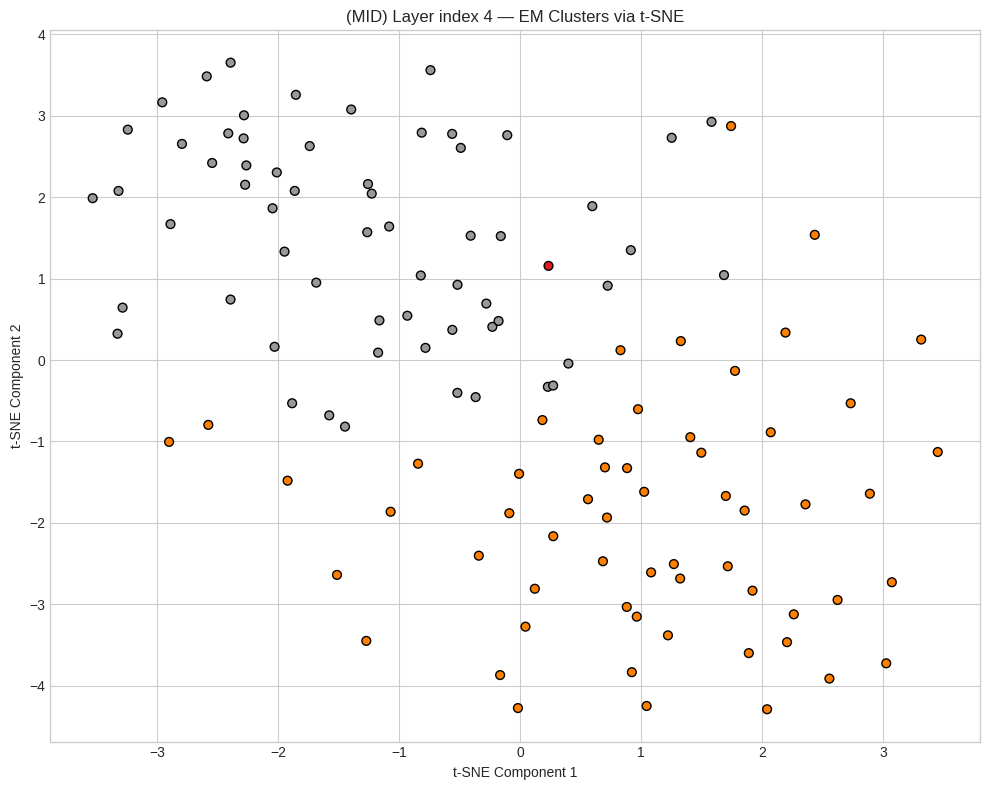


--- Clustering Neuron Activity from Layer index: 7 (MID) ---
Clustering Accuracy (MID): 0.5167
Confusion Matrix:
 [[18 15  7]
 [16 22  2]
 [ 3 15 22]]


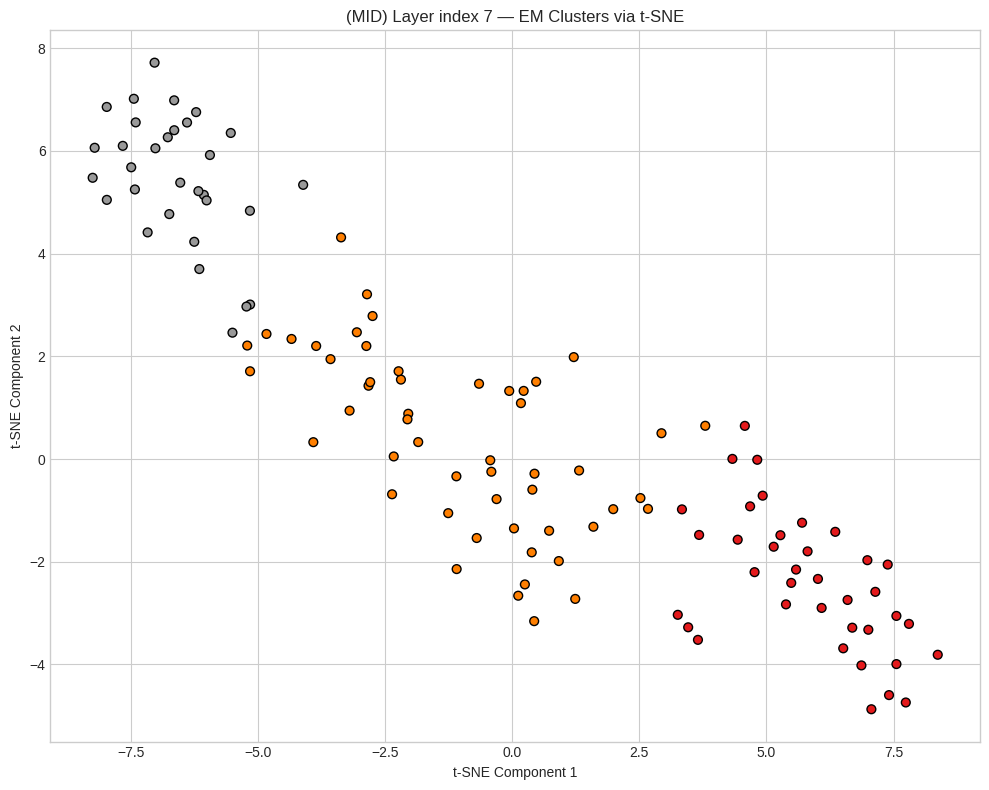


========== TRAINING: Second Half ==========
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.4738 - loss: 1.3499 - val_accuracy: 0.4667 - val_loss: 1.2955
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.5078 - loss: 1.2826 - val_accuracy: 0.4417 - val_loss: 1.3212
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5047 - loss: 1.3257 - val_accuracy: 0.4833 - val_loss: 1.2965
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.5108 - loss: 1.2639 - val_accuracy: 0.4833 - val_loss: 1.2968
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5643 - loss: 1.2278 - val_accuracy: 0.4750 - val_loss: 1.2816
Epoch 16/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5698 - loss: 1.2286 - val_accuracy: 0.4917 - val_loss: 1.2623
Epoch 17/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.5638 - loss: 1.2340 - val_accuracy: 0.5000 - val_loss: 1.3041
Epoch 18/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step

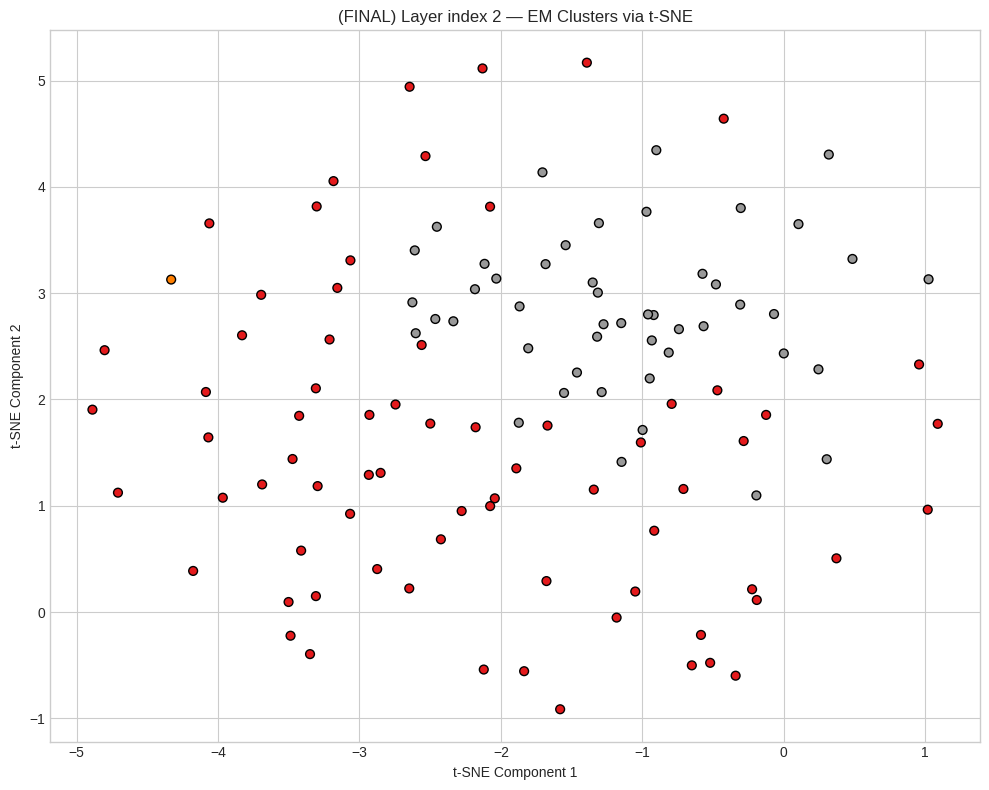


--- Clustering Neuron Activity from Layer index: 4 (FINAL) ---
Clustering Accuracy (FINAL): 0.5000
Confusion Matrix:
 [[21  0 19]
 [13  1 26]
 [ 2  0 38]]


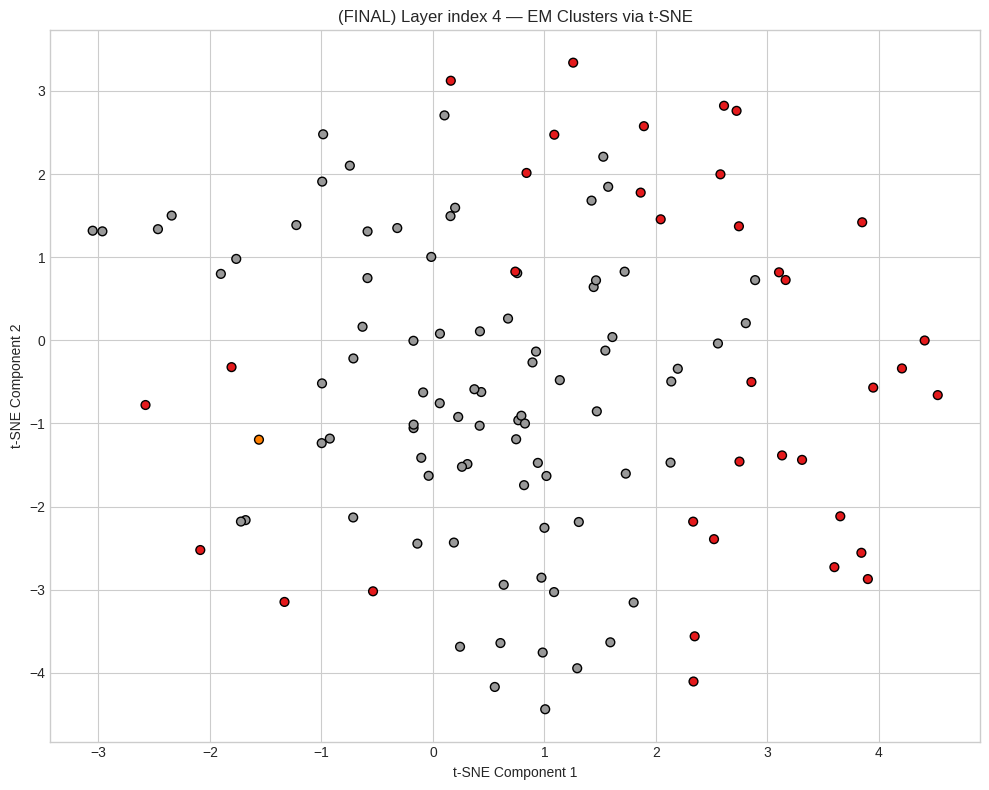


--- Clustering Neuron Activity from Layer index: 7 (FINAL) ---
Clustering Accuracy (FINAL): 0.4833
Confusion Matrix:
 [[14 17  9]
 [ 9 15 16]
 [ 3  8 29]]


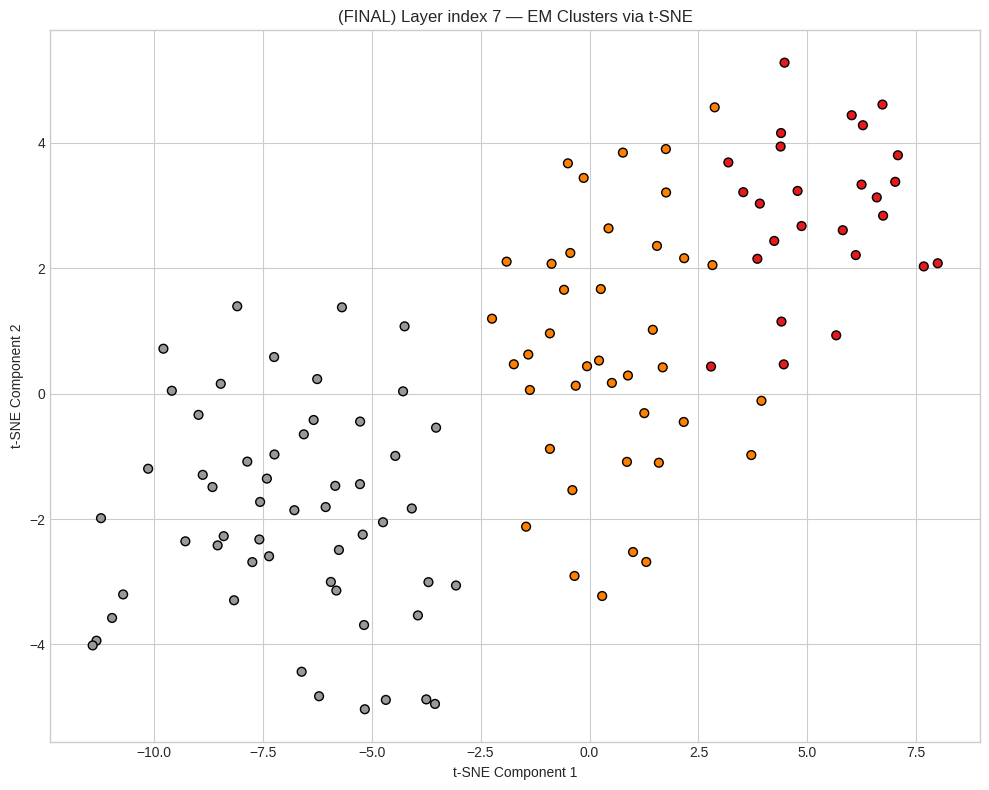

In [ ]:
# Define model
inputs = tf.keras.Input(shape=(64, 64, 3))
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax',
                       kernel_regularizer=regularizers.l2(0.001))(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile using SGD optimizer with default learning rate (0.01) + momentum
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary and training
model.summary()

# --------- CLUSTERING UTILS ---------
def get_activations(model, layer_index, dataset):
    intermediate_layer_model = tf.keras.Model(
        inputs=model.input,
        outputs=model.layers[layer_index].output
    )
    activations = []
    labels = []
    for batch, label in dataset:
        act = intermediate_layer_model(batch, training=False)
        activations.append(tf.reshape(act, [act.shape[0], -1]).numpy())
        labels.append(label.numpy())
    return np.vstack(activations), np.argmax(np.vstack(labels), axis=1)

def match_labels(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-matrix)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    return np.array([mapping[p] for p in y_pred])

def cluster_and_visualize(model, val_ds, layer_indices, tag):
    for layer_index in layer_indices:
        print(f"\n--- Clustering Neuron Activity from Layer index: {layer_index} ({tag}) ---")
        activations, y_true = get_activations(model, layer_index, val_ds)
        pca = PCA(n_components=0.95, random_state=42)
        reduced = pca.fit_transform(activations)
        gm = GaussianMixture(n_components=3, random_state=42).fit(reduced)
        preds = gm.predict(reduced)
        aligned_preds = match_labels(y_true, preds)
        acc = accuracy_score(y_true, aligned_preds)
        cm = confusion_matrix(y_true, aligned_preds)
        print(f"Clustering Accuracy ({tag}): {acc:.4f}")
        print("Confusion Matrix:\n", cm)
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        tsne_data = tsne.fit_transform(reduced)
        plt.figure(figsize=(10, 8))
        plt.title(f"({tag}) Layer index {layer_index} — EM Clusters via t-SNE")
        plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=aligned_preds, cmap='Set1', s=40, edgecolors='k')
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.tight_layout()
        plt.show()

# --------- RUN TRAINING + ANALYSIS ---------
layers_to_use = [2, 4, 7]

print("\n========== TRAINING: First Half ==========")
history_1 = model.fit(train_ds, validation_data=val_ds, epochs=10)

print("\n========== MID TRAINING ANALYSIS ==========")
cluster_and_visualize(model, val_ds, layers_to_use, tag="MID")

print("\n========== TRAINING: Second Half ==========")
history_2 = model.fit(train_ds, validation_data=val_ds, initial_epoch=10, epochs=20)

print("\n========== FINAL TRAINING ANALYSIS ==========")
cluster_and_visualize(model, val_ds, layers_to_use, tag="FINAL")

Clustering in the first layer showed no improvement over the course of training. In the middle clusters began to form, but still lacked clear and decisive seperation. The end layer showed string clustering with less misidentification.